In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('data/glass.csv')
df = df.drop(columns=['idx'])

In [6]:
print(df.head())

        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  class
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0      1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0      1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0      1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0      1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0      1


# Eksploracja danych

In [7]:
print(df.shape)

(214, 10)


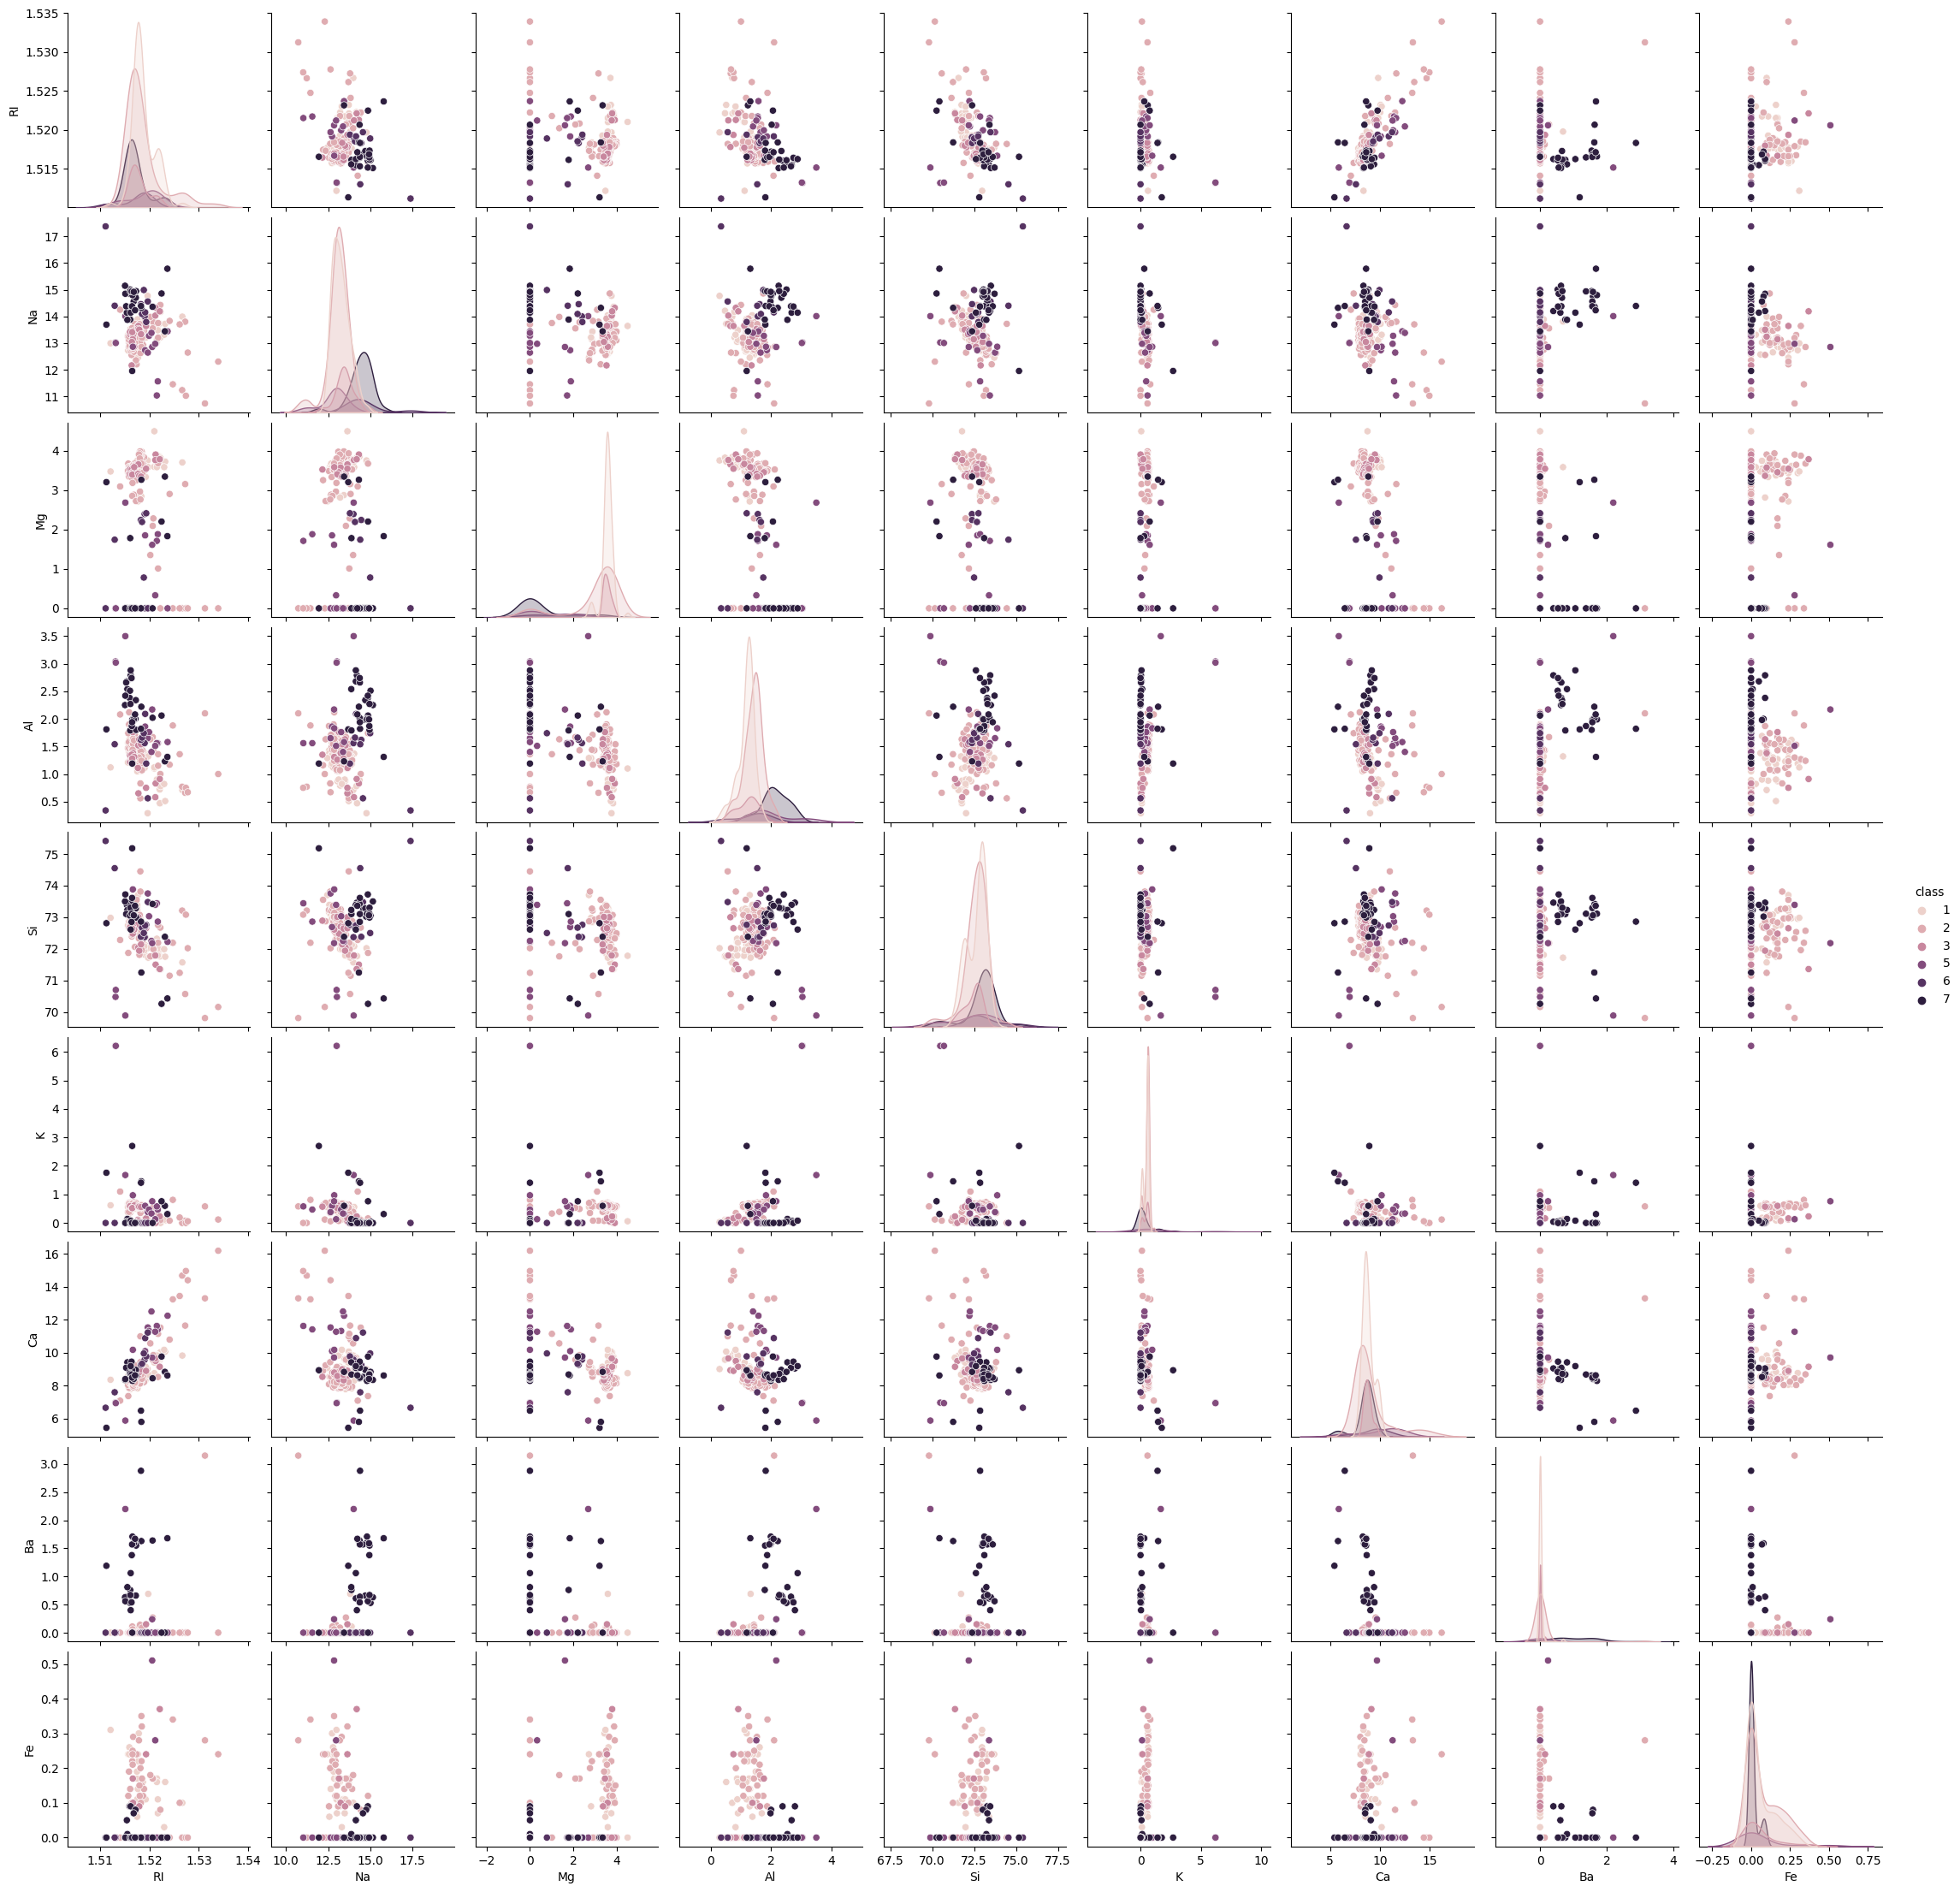

In [37]:
import seaborn as sns
sns.pairplot(df, hue='class');

In [9]:
print(df.describe())

               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe       class  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000    0.000000    0.000000    1

In [10]:
print(df['class'].value_counts())

2    76
1    70
7    29
3    17
5    13
6     9
Name: class, dtype: int64


In [11]:
print(df.corr())

             RI        Na        Mg        Al        Si         K        Ca  \
RI     1.000000 -0.191885 -0.122274 -0.407326 -0.542052 -0.289833  0.810403   
Na    -0.191885  1.000000 -0.273732  0.156794 -0.069809 -0.266087 -0.275442   
Mg    -0.122274 -0.273732  1.000000 -0.481799 -0.165927  0.005396 -0.443750   
Al    -0.407326  0.156794 -0.481799  1.000000 -0.005524  0.325958 -0.259592   
Si    -0.542052 -0.069809 -0.165927 -0.005524  1.000000 -0.193331 -0.208732   
K     -0.289833 -0.266087  0.005396  0.325958 -0.193331  1.000000 -0.317836   
Ca     0.810403 -0.275442 -0.443750 -0.259592 -0.208732 -0.317836  1.000000   
Ba    -0.000386  0.326603 -0.492262  0.479404 -0.102151 -0.042618 -0.112841   
Fe     0.143010 -0.241346  0.083060 -0.074402 -0.094201 -0.007719  0.124968   
class -0.164237  0.502898 -0.744993  0.598829  0.151565 -0.010054  0.000952   

             Ba        Fe     class  
RI    -0.000386  0.143010 -0.164237  
Na     0.326603 -0.241346  0.502898  
Mg    -0.492262 

# Przygotowanie danych

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

In [13]:
SEED = 222
TEST_SIZE = 0.2
X = df.drop(['class'], axis=1)
y = df['class']

In [14]:
def split_train_test_data(X, y, test_size=TEST_SIZE, seed=SEED):
    return train_test_split(X, y, test_size=test_size, random_state=seed)

In [15]:
def create_pipeline(classifier, preprocessing):
    pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', classifier)
    ])

    return pipeline

In [16]:
def evaluate_model(y_true, y_pred):
    metrics = {
        'F1 Score': f1_score(y_true, y_pred, average='micro'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred, average='micro'),
        'Precision': precision_score(y_true, y_pred, average='micro')
    }

    return metrics

# Define the classifiers and their hyperparameter grids

In [17]:
classifiers = [
    ('Naive Bayes', GaussianNB(), {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
    }),
    ('Decision Tree', DecisionTreeClassifier(random_state=SEED), {
        'classifier__max_depth': [None, 5, 10],
        'classifier__criterion': ['gini', 'entropy']
    }),
    ('Random Forest', RandomForestClassifier(random_state=SEED), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 5]
    })
]

# Define the preprocessors


In [18]:
preprocessors = [
    ('None', None, {}),
    ('Normalization', StandardScaler(), {
        'preprocessing__with_mean': [True, False],
        'preprocessing__with_std': [True, False]
    }),
    ('Feature Selection', SelectKBest(score_func=f_classif), {
        'preprocessing__k': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    }),
    ('PCA', PCA(), {
        'preprocessing__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9]
    })
]

In [19]:
results = []

cv = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

for prep_name, preprocessor, params_p in preprocessors:
    for clf_name, classifier, params_c in classifiers:
        pipeline = create_pipeline(classifier, preprocessor)
        params = {
            **params_c,
            **params_p
        }

        grid_search = GridSearchCV(pipeline, params, scoring='f1_micro', cv=cv)
        grid_search.fit(X, y)
        best_estimator = grid_search.best_estimator_

        # Collect the results
        result = {
            'Preprocessor': prep_name,
            'Classifier': clf_name,
            'Best Parameters': grid_search.best_params_,
            'F1 Score': grid_search.best_score_
        }
        results.append(result)

In [20]:
import json

sorted_results = sorted(results, key=lambda x: x['F1 Score'], reverse=True)
results_str = json.dumps(sorted_results, indent=4)
print(results_str)

[
    {
        "Preprocessor": "Normalization",
        "Classifier": "Random Forest",
        "Best Parameters": {
            "classifier__max_depth": null,
            "classifier__n_estimators": 200,
            "preprocessing__with_mean": true,
            "preprocessing__with_std": false
        },
        "F1 Score": 0.8128460686600221
    },
    {
        "Preprocessor": "None",
        "Classifier": "Random Forest",
        "Best Parameters": {
            "classifier__max_depth": null,
            "classifier__n_estimators": 200
        },
        "F1 Score": 0.8080841638981173
    },
    {
        "Preprocessor": "Feature Selection",
        "Classifier": "Random Forest",
        "Best Parameters": {
            "classifier__max_depth": null,
            "classifier__n_estimators": 200,
            "preprocessing__k": 9
        },
        "F1 Score": 0.8080841638981173
    },
    {
        "Preprocessor": "None",
        "Classifier": "Decision Tree",
        "Best Paramete

In [33]:
X_train, X_test, y_train, y_test = split_train_test_data(X, y)
pipeline = create_pipeline(RandomForestClassifier(n_estimators=200), StandardScaler(with_std=False))

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
metrics = evaluate_model(y_test, y_pred)
print(metrics)

{'F1 Score': 0.8372093023255814, 'Accuracy': 0.8372093023255814, 'Recall': 0.8372093023255814, 'Precision': 0.8372093023255814}


Confusion Matrix:
[[12  4  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 1  0  2  0  0  0]
 [ 0  1  0  3  0  0]
 [ 0  0  0  0  1  0]
 [ 0  1  0  0  0  8]]


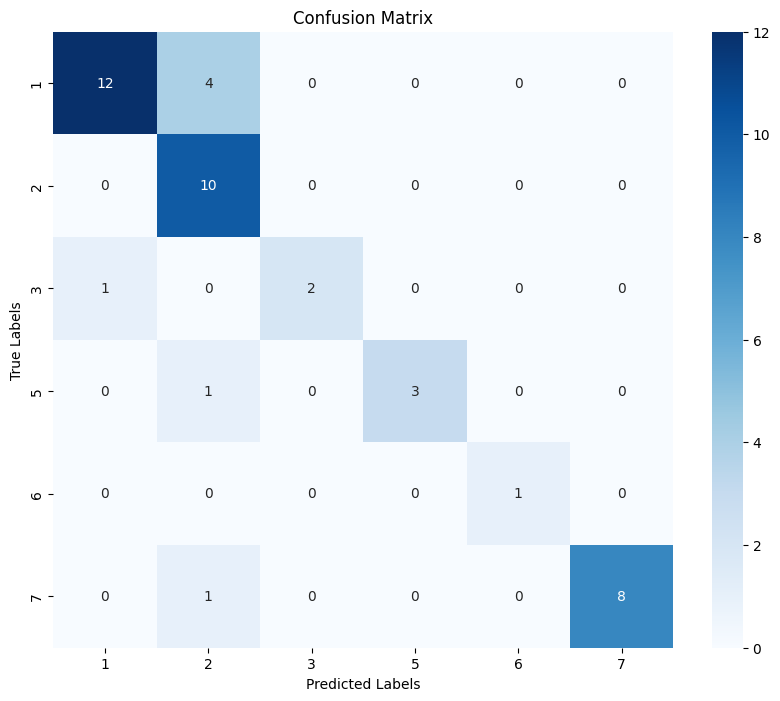

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)
class_labels = ['1', '2', '3', '5', '6', '7']

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

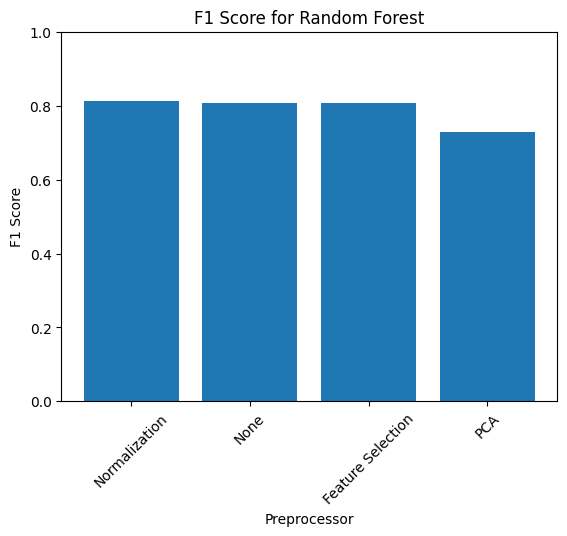

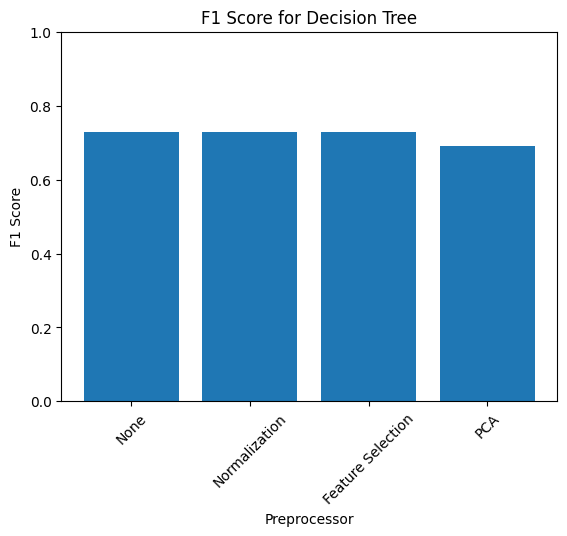

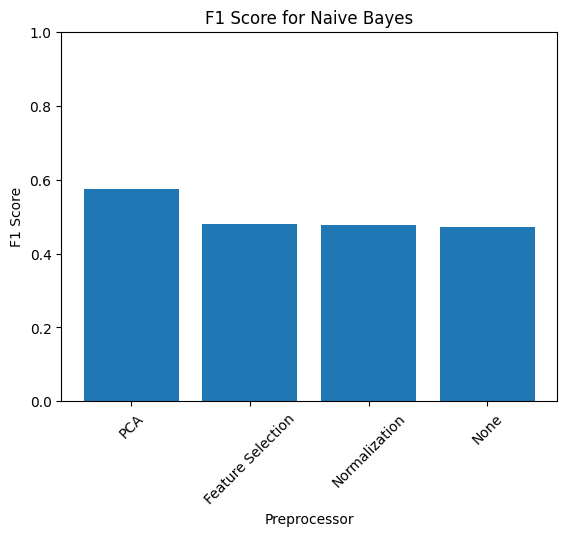

In [35]:
df_results = pd.DataFrame(sorted_results)

classifiers = df_results['Classifier'].unique()

for clf_name in classifiers:
    clf_results = df_results[df_results['Classifier'] == clf_name]
    plt.figure()
    plt.bar(clf_results['Preprocessor'], clf_results['F1 Score'])
    plt.title(f'F1 Score for {clf_name}')
    plt.xlabel('Preprocessor')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()